# 09wk-2: 중간고사 (예상문제)

최규빈  
2024-05-01

In [1]:
import torch 
import torchvision
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import fastai.vision.all

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/09wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

> **중간고사 관련 안내**
>
> -   개인노트북, 개인태블릿 등 사용가능함. (배터리 충전기 및 와이파이는
>     제공하지 않음)
> -   부정행위 (카카오톡 채팅을 통한 코드공유, 대리시험 등) 적발시 F
>     처리함.
> -   답안은 `.ipynb` 파일로 제출할 것.

# `1`. 크롤링을 통한 이미지 분석 및 CAM – 30점

`(1)` 두 가지 키워드로 크롤링을 수행하여 이미지자료를 모아라. (키워드는
각자 마음에 드는 것으로 설정할 것) – 01wk-1 의 HW를 그대로 활용해도 무방

`(2)` ImageDataLoaders.from_folder 를 이용하여 dls를 만들어라.

`(3)` resnet34를 이용하여 학습하라.

`(4)` CAM (class activation mapping)을 이용하여 (3)의 모형의 판단근거를
시각화하라.

# `2`. 생성모형 / GAN – 40점

아래는 `torchvision`을 활용하여 MNIST 데이터를 불러오고 `DataLoader`를
생성하는 코드이다.

In [2]:
# Data preprocessing
ds = dataset = torchvision.datasets.MNIST(
    root = './data',
    download=True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(64), # 이미지를 (64,64)로 resize 
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))
    ])
)
# Dataloader
dl = torch.utils.data.DataLoader(
    ds, 
    batch_size=120,
    shuffle=True, 
)

`(1)` `iter`와 `next`를 이용하여 데이터로더의 첫번째 배치를 출력하라.
하나의 배치에 몇개의 이미지가 있는가? 이미지는 흑백인가 칼라인가?
이미지의 크기는 얼마인가?

(풀이)

**힌트:** 120개의 배치가 있고, 흑백이미지이며, 이미지의 크기는
(64,64)임.

`(2)` 아래의 함수를 이용하여 하나의 배치에 포함된 이미지를 출력하라.

In [7]:
def imshow(xi_real):
    plt.imshow(torch.einsum('cij->ijc',torchvision.utils.make_grid(xi_real, padding=2, normalize=True)))

(풀이)

**힌트**: 출력예시는 아래와 같다. 여기에서 `xi_real.shape`은
(120,1,64,64) 이다.

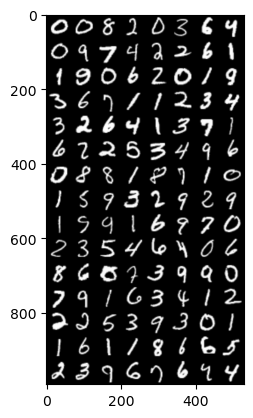

In [8]:
imshow(xi_real)

`(3)` 아래의 코드를 이용하여 `net_police`를 생성하라.

In [9]:
net_police = torch.nn.Sequential(
    # Layer1
    torch.nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.LeakyReLU(0.2),
    # Layer2
    torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(128),
    torch.nn.LeakyReLU(0.2),
    # Layer3
    torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(256),
    torch.nn.LeakyReLU(0.2),
    # Layer4
    torch.nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(512),
    torch.nn.LeakyReLU(0.2),
    # Layer5
    torch.nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    torch.nn.Sigmoid(),
    torch.nn.Flatten()
)

`net_police`에 하나의 배치를 넣어보고 각 층별 출력크기를 조사하라.

(풀이)

**hint** 정답예시는 아래와 같다.

    xi_real -- torch.Size([120, 1, 64, 64])
    Layer1 -- torch.Size([120, 64, 32, 32])
    Layer2 -- torch.Size([120, 128, 16, 16])
    Layer3 -- torch.Size([120, 256, 8, 8])
    Layer4 -- torch.Size([120, 512, 4, 4])
    Layer5 -- torch.Size([120, 1])

`(4)` 아래의 코드를 이용하여 `net_faker`를 생성하라.

In [12]:
net_faker = torch.nn.Sequential(
    # Layer1
    torch.nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, padding=0, bias=False),
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(),
    # Layer2
    torch.nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(256),
    torch.nn.ReLU(),
    # Layer3
    torch.nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(),
    # Layer4
    torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    # Layer5
    torch.nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.Tanh()
)

`net_faker`에 아래의 noise를 넣어보고 각 층별 출력크기를 조사하라.

``` python
ni = torch.randn(batch_size, 100, 1, 1)
```

(풀이)

**hint**: 여기에서 `batch_size`는 (1)에서 조사한 batch_size(=120)를 넣을
것

**hint:** 정답예시는 아래와 같다.

    ni -- torch.Size([120, 100, 1, 1])
    Layer1 -- torch.Size([120, 512, 4, 4])
    Layer2 -- torch.Size([120, 256, 8, 8])
    Layer3 -- torch.Size([120, 128, 16, 16])
    Layer4 -- torch.Size([120, 64, 32, 32])
    Layer5 -- torch.Size([120, 1, 64, 64])

`(5)` 아래와 같이 두개의 `optimizr` 를 선언하라.

In [17]:
optimizr_police = torch.optim.Adam(net_police.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizr_faker = torch.optim.Adam(net_faker.parameters(), lr=0.0002, betas=(0.5, 0.999))

아래의 세부지침에 맞추어 `net_police` 와 `net_faker`를 학습하라.

1.  5 epochs 을 진행하여 학습할 것
2.  GPU를 이용하여 학습할 것

(풀이)

**hint** 아래와 같은 얼개로 사용하면된다. ?? 와 .. 에 해당하는 부분은
적당히 채울것

``` python
# 08wk-1,2 - G 에서 제시된 코드를 살짝 변형하여 풀면 됩니다
for epoc in range(5):
    for ?? , _ in dl:
        # net_police 을 훈련
        ...
        ...
        # net_faker 를 훈련
        ...
        ...
```

`(6)` 학습결과를 (2)의 imshow 함수를 이용하여 시각화하라.

(풀이)

**hint** 시각화 예시는 아래와 같다.

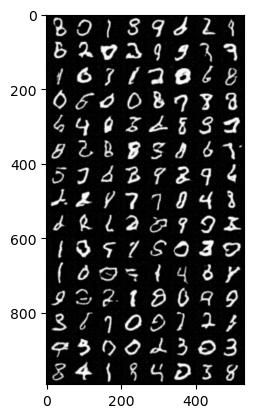

In [26]:
ni = torch.randn(120, 100, 1, 1).to("cuda:0")
xi_fake = net_faker(ni).data.to("cpu")
imshow(xi_fake)